# API KEYS


In [1]:
from google.colab import userdata

LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')
PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')
OPENAI_API_KEY = userdata.get('openai_key')

# LANGSMITH TRACING

In [2]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "subrata-raptor"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY

In [3]:
!pip install -U langchain umap-learn scikit-learn langchain_community tiktoken langchain-openai langchainhub langchain-chroma pypdf langchain-anthropic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.6/866.6 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 31.9 MB/s eta 

# RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval

The [RAPTOR](https://arxiv.org/pdf/2401.18059.pdf) paper presents an interesting approaching for indexing and retrieval of documents:

* The `leafs` are a set of starting documents
* Leafs are embedded and clustered
* Clusters are then summarized into higher level (more abstract) consolidations of information across similar documents

This process is done recursivly, resulting in a "tree" going from raw docs (`leafs`) to more abstract summaries.

We can applying this at varying scales; `leafs` can be:

* Text chunks from a single doc (as shown in the paper)
* Full docs (as we show below)

With longer context LLMs, it's possible to perform this over full documents.

![Screenshot 2024-03-04 at 12.45.25 PM.png](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F0202b05c-e0ab-4d22-aaf7-e8019158efcf_1810x1356.png)

# PDF & DOCX LOADING

In [4]:
def load_document(file):
  import os

  print("Detecting file type ...")
  name, extension = os.path.splitext(file)
  print(f"{extension[1:]} file type detected!")

  print(f"Loading {file} ...")

  if extension == ".pdf":
    from langchain_community.document_loaders import PyPDFLoader

    loader = PyPDFLoader(file)
    pages = loader.load_and_split()

    print(f"{len(pages)} pages parsed successfully!")
    print("Done!")
    return pages

  elif extension == ".docx":
    from langchain_community.document_loaders import Docx2txtLoader

    loader = Docx2txtLoader(file)
    pages = loader.load_and_split()

    print(f"{len(pages)} pages parsed successfully!")
    print("Done!")
    return pages

  else:
    print(f"Unfortunately! {extension} is not supported")

In [5]:
# loading the document
pages = load_document("/content/accounting.pdf")

Detecting file type ...
pdf file type detected!
Loading /content/accounting.pdf ...


387 pages parsed successfully!
Done!


In [6]:
for page in pages[:3]:
  display(page)
  print("="*100)

Document(metadata={'source': '/content/accounting.pdf', 'page': 0}, page_content='CHAPTER 1 UNIT - 1  1.MEANING AND SCOPE OF ACCOUNTING 1.INTRODUCTION Every individual performs some kind of economic activity. A salaried person gets salary and spends to buy provisions and clothing, for children\'s education, construction of house, etc. A sports club formed by a group of individuals, a business run by an individual or a group of individuals, a company running a business in telecom sector, a local authority like Calcutta Municipal Corporation, Delhi Development Authority, Governments, either Central or State, all are carrying some kind of economic activities. Not necessarily all the economic activities are run for any individual benefit; such economic activities may create social benefit i.e. benefit for the public, at large. Anyway, such economic activities are performed through \'transactions and events\'. Transaction is used to mean \'a business, performance of an act, an agreement\' w

Document(metadata={'source': '/content/accounting.pdf', 'page': 1}, page_content='transactions (transactions made by the user, raising invoice to the customer, receipt of money, payment towards salaries, marketing etc.). Likewise, the individual running the stationery business, would need to record all business transactions. This recording is done in Journal or subsidiary books, also known as primary books. Every good record keeping system includes suitable classification of transactions and events as well as their summarisation for ready reference. For example, the telecom company performing thousands of transactions on a daily basis, is not expected to publish all those transactions for the users to be able to make a decision. Surely, those transactions need to be summarized appropriately. After the transactions and events are recorded, they are transferred to secondary books, i.e., Ledger. In ledger, transactions and events are classified in terms of income, expense, assets and liab

Document(metadata={'source': '/content/accounting.pdf', 'page': 2}, page_content='"The function of accounting is to provide quantitative information, primarily of financial nature, about economic entities, that is needed to be useful in making economic decisions." Thus, accounting may be defined as the process of recording, classifying, summarising, analysing and interpreting the financial transactions and communicating the results thereof to the persons interested in such information. The above definition requires accountants to assume a bigger responsibility than to merely do book-keeping. Accountants need to be ready to provide the information ready for the intended users to be able to make economic decisions. 2.1.Procedural aspects of Accounting On the basis of the above definitions, procedure of accounting can be basically divided into two parts: i.Generating financial information and ii.Using the financial information. Generating Financial Information 1.Recording - This is the ba

### Docs

Let's apply this to LangChain's LCEL documentation.

In this case, each `doc` is a unique web page of the LCEL docs.

The context varies from < 2k tokens on up to > 10k tokens.

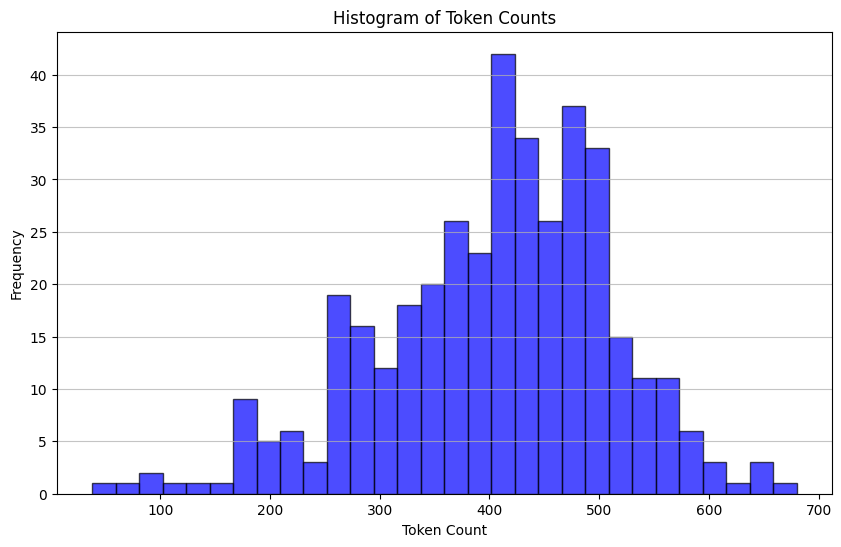

In [7]:
import matplotlib.pyplot as plt
import tiktoken
import os

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

if pages:
    # Extract text from the loaded pages
    docs_texts = [page.page_content for page in pages]

    # Calculate the number of tokens for each document
    counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

    # Plotting the histogram of token counts
    plt.figure(figsize=(10, 6))
    plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
    plt.title("Histogram of Token Counts")
    plt.xlabel("Token Count")
    plt.ylabel("Frequency")
    plt.grid(axis="y", alpha=0.75)

    # Display the histogram
    plt.show()
else:
    print("Failed to load the document.")

In [8]:
from langchain_core.documents import Document
if pages:
    # Convert pages to Document objects if they aren't already
    docs = [
        Document(page_content=page.page_content, metadata={"source": f"page_{i}"})
        for i, page in enumerate(pages)
    ]

    # Sort documents by source (in this case, page number)
    d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
    d_reversed = list(reversed(d_sorted))

    # Concatenate content with separators
    concatenated_content = "\n\n\n --- \n\n\n".join(
        [doc.page_content for doc in d_reversed]
    )

    # Count tokens in concatenated content
    total_tokens = num_tokens_from_string(concatenated_content, "cl100k_base")
    print(f"Num tokens in all context: {total_tokens}")

    # You can add the histogram plotting code here if needed

else:
    print("Failed to load the document.")

Num tokens in all context: 157587


In [11]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)

## Models

We can test various models, including the new [Claude3](https://www.anthropic.com/news/claude-3-family) family.

Be sure to set the relevant API keys:

* `ANTHROPIC_API_KEY`
* `OPENAI_API_KEY`

In [12]:
!pip install langchain_openai -q

In [13]:
from langchain_openai import OpenAIEmbeddings

embd = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0, model="gpt-4o", openai_api_key=OPENAI_API_KEY)

# from langchain_anthropic import ChatAnthropic

# model = ChatAnthropic(temperature=0, model="claude-3-opus-20240229")

### Tree Constrution

The clustering approach in tree construction includes a few interesting ideas.

**GMM (Gaussian Mixture Model)**

- Model the distribution of data points across different clusters
- Optimal number of clusters by evaluating the model's Bayesian Information Criterion (BIC)

**UMAP (Uniform Manifold Approximation and Projection)**

- Supports clustering
- Reduces the dimensionality of high-dimensional data
- UMAP helps to highlight the natural grouping of data points based on their similarities

**Local and Global Clustering**

- Used to analyze data at different scales
- Both fine-grained and broader patterns within the data are captured effectively

**Thresholding**

- Apply in the context of GMM to determine cluster membership
- Based on the probability distribution (assignment of data points to ≥ 1 cluster)
---

Code for GMM and thresholding is from Sarthi et al, as noted in the below two sources:

* [Origional repo](https://github.com/parthsarthi03/raptor/blob/master/raptor/cluster_tree_builder.py)
* [Minor tweaks](https://github.com/run-llama/llama_index/blob/main/llama-index-packs/llama-index-packs-raptor/llama_index/packs/raptor/clustering.py)

Full credit to both authors.

In [14]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of Accounting Docs.

    Accounting is the measurement, processing, and communication of financial information about economic entities such as businesses and corporations.

    Give a detailed summary of the documentation provided.

    Documents:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [15]:
# Build tree
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 85 clusters--
--Generated 18 clusters--
--Generated 5 clusters--


The paper reports best performance from `collapsed tree retrieval`.

This involves flattening the tree structure into a single layer and then applying a k-nearest neighbors (kNN) search across all nodes simultaneously.

We do simply do this below.

In [16]:
from langchain_chroma import Chroma

# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()

Now we can using our flattened, indexed tree in a RAG chain.

In [17]:
%%time
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")
print(prompt)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

input_variables=['context', 'question'] metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))]
CPU times: user 401 ms, sys: 125 ms, total: 526 ms
Wall time: 726 ms


In [18]:
# Question
rag_chain.invoke("What are the procedural aspects of accounting?")

'The procedural aspects of accounting involve two main parts: generating financial information and using the financial information. Generating financial information includes recording transactions in a journal, classifying them in a ledger, summarizing the data into financial statements, analyzing the relationships within the data, interpreting the results, and communicating the information to stakeholders. Using the financial information involves applying it for decision-making, assessing financial positions, and evaluating solvency.'

Trace:

[Langsmith Tracing](https://smith.langchain.com/o/031f512a-5f48-55bf-8bda-4900f31f2bf4/projects/p/ed8c446b-8389-4ac5-8afb-7d3b9884b4bd/r/ef716d54-7d4d-442d-8d57-60e3d9a41d91?trace_id=605a0a35-d92a-40a2-a75d-ef76633f04e4&start_time=2024-08-06T08:33:54.900735)